In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/videogames-cnn-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: videogames-cnn-dataset/train/Fortnite/fortnite1_18-001763.jpg  
  inflating: videogames-cnn-dataset/train/Fortnite/fortnite1_19-000001.jpg  
  inflating: videogames-cnn-dataset/train/Fortnite/fortnite3_15-000071.jpg  
  inflating: videogames-cnn-dataset/train/Fortnite/fortnite1_13-000461.jpg  
  inflating: videogames-cnn-dataset/train/Fortnite/fortnite1_14-000162.jpg  
  inflating: videogames-cnn-dataset/train/Fortnite/fortnite1_8-000231.jpg  
  inflating: videogames-cnn-dataset/train/Fortnite/fortnite1_9-000881.jpg  
  inflating: videogames-cnn-dataset/train/Fortnite/fortnite3_15-001409.jpg  
  inflating: videogames-cnn-dataset/train/Fortnite/fortnite2_9-000309.jpg  
  inflating: videogames-cnn-dataset/train/Fortnite/fortnite1_15-000287.jpg  
  inflating: videogames-cnn-dataset/train/Fortnite/fortnite3_11-000024.jpg  
  inflating: videogames-cnn-dataset/train/Fortnite/fortnite4_4-001013.jpg  
  inflating: videogames-cnn-d

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.regularizers import l2
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Dense, AveragePooling2D, Flatten, MaxPooling2D
import os, sys
import io

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
#Connect to the TPU handle and initialise it
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.61.163.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.61.163.18:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [ ]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
def get_training_set():
    train_path = "videogames-cnn-dataset/train"

    training_set = tf.keras.preprocessing.image_dataset_from_directory(
        train_path,
        labels="inferred",
        image_size=(224, 224),
        batch_size=64,
        shuffle=True,
        label_mode='categorical'
    )

    return training_set

def get_test_set():
    test_path = "videogames-cnn-dataset/test"

    testing_set = tf.keras.preprocessing.image_dataset_from_directory(
        test_path,
        labels="inferred",
        image_size=(224, 224),
        batch_size=64,
        shuffle=True,
        label_mode='categorical'
    )

    return testing_set

In [ ]:
def bottleneck_residual_block(X, kernel_size, filters, reduce=False, s=2):
    F1, F2, F3 = filters

    X_Shortcut = X

    if reduce:
        X_Shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), kernel_regularizer=l2(0.0001))(X_Shortcut)
        X_Shortcut = BatchNormalization(axis=3)(X_Shortcut)

        X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.0001))(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)
    else:
        X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1),  padding='valid', kernel_regularizer=l2(0.0001))(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=kernel_size, strides=(1, 1), padding='same', kernel_regularizer=l2(0.0001))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.0001))(X)
    X = BatchNormalization(axis=3)(X)

    X = Add()([X, X_Shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def resnet101_model(input_shape, classes):

    X_input = Input(shape=input_shape)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_regularizer=l2(0.0001))(X_input)
    X = BatchNormalization(axis=3, name="bn_conv1")(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = bottleneck_residual_block(X, 3, [64, 64, 256], reduce=True, s=1)
    X = bottleneck_residual_block(X, 3, [64, 64, 256])
    X = bottleneck_residual_block(X, 3, [64, 64, 256])

    X = bottleneck_residual_block(X, 3, [128, 128, 512], reduce=True, s=2)
    for _ in range(0, 3):
        X = bottleneck_residual_block(X, 3, [128, 128, 512])

    X = bottleneck_residual_block(X, 3, [256, 256, 1024], reduce=True, s=2)
    for _ in range(0, 22):
        X = bottleneck_residual_block(X, 3, [256, 256, 1024])

    X = bottleneck_residual_block(X, 3, [512, 512, 2048], reduce=True, s=2)
    X = bottleneck_residual_block(X, 3, [512, 512, 2048])
    X = bottleneck_residual_block(X, 3, [512, 512, 2048])

    X = AveragePooling2D((1,1))(X)

    X = Flatten()(X)

    X = Dense(classes, activation="softmax", name='fc' + str(classes))(X)

    model = Model(inputs = X_input, outputs = X, name='ResNet101')

    return model

In [ ]:
training_set = get_training_set()
testing_set = get_test_set()

Found 115496 files belonging to 21 classes.
Found 16971 files belonging to 21 classes.


In [ ]:
train_aug = Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./ 255),
    tf.keras.layers.experimental.preprocessing.Resizing(
        height=224,
        width=224
    ),
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.03, fill_mode='nearest',  interpolation='bilinear'),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(
        height_factor=0.12,
        width_factor=0.12,
        fill_mode='nearest',
        interpolation='bilinear'
    ),
    tf.keras.layers.experimental.preprocessing.RandomZoom(
        height_factor=(-0.0, -0.12),
        width_factor=(-0.0, -0.12),
        fill_mode='nearest',
        interpolation='bilinear'
    )
])

In [ ]:
test_aug = Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./ 255),
    tf.keras.layers.experimental.preprocessing.Resizing(
        height=224,
        width=224
    ),
])

In [ ]:
training_dataset = (
    training_set
    .shuffle(128 * 100)
    .unbatch()
    .batch(128*8)
    .map(lambda x, y: (train_aug(x), y),
    num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
testing_dataset = (
    testing_set
    .shuffle(128 * 50)
    .unbatch()
    .batch(128*8)
    .map(lambda x, y: (test_aug(x), y),
    num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
model = resnet101_model((224, 224, 3), 21)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "ResNet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 109, 109, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 109, 109, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 109, 109, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________

In [ ]:
# lr_scheduler = LearningRateScheduler(scheduler)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.000001)
# early_stopper = EarlyStopping(monitor='loss', patience=10, mode='auto')
checkpointer = ModelCheckpoint('/content/drive/MyDrive/videogames/weights.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
model.load_weights("/content/drive/MyDrive/weightsCopy.hdf5")

In [ ]:
model.fit(
    training_set,
    validation_data = testing_set,
    # validation_split = 0.2,
    epochs = 50,
    # batch_size = 100,
    callbacks=[lr_reducer, checkpointer] # salsa choque
)

Epoch 1/50


UnimplementedError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.regularizers import l2
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Dense, AveragePooling2D, Flatten, MaxPooling2D
import os, sys
import io
from tensorflow.keras.applications.inception_resnet_v2 import decode_predictions
import numpy as np
import heapq
import pandas as pd

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/weights-14.hdf5")

/usr/local/lib/python3.7/dist-packages/keras/layers/core.py:1045: UserWarning: tensorflow.python.keras.applications.inception_resnet_v2 is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [ ]:
model.load_weights("/content/drive/MyDrive/videogames/checkpoints/weights.hdf5")

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
class_labels = [
  'Apex',
  'Csgo',
  'Clash Royale',
  "Deadth By Daylight",
  'Dota2',
  "Escape From Tarkov",
  "Fifa21",
  "Fortnite",
  "Free fire",
  "GtaV",
  "Lol",
  "Minecraft",
  "Overwatch",
  "pubg",
  "rainbows",
  "rocket league",
  "rust",
  "sea of thieves",
  "valorant",
  "warzone",
  "wow",
]

In [ ]:
print(len(class_labels))

21


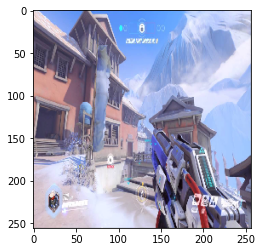

[ 0.   0.   0.   0.   0.   0.   0.   0.1  0.   0.   0.   0.  99.9  0.
  0.   0.   0.   0.   0.   0.   0. ]
Overwatch: 99.9000015258789


In [ ]:
test_image = '/content/drive/MyDrive/sapotoro_35.jpeg' #dota
img = tf.keras.preprocessing.image.load_img(test_image, target_size=(256,256))

img_array = tf.keras.preprocessing.image.img_to_array(img)

img_array = img_array / 255

plt.imshow(img_array)
plt.show()

img_array = tf.expand_dims(img_array, 0) # Create a batch


prediction = model.predict(img_array)
prediction_array = np.array(prediction[0])
prediction_array = prediction_array.round(decimals=3)
# prediction_array = prediction_array.argsort()
prediction_array = prediction_array * 100
print(prediction_array)

top1Arg = prediction_array.argmax()
top_1_prediction = prediction_array[top1Arg]
top_1_label = class_labels[top1Arg]

print(f"{top_1_label}: {top_1_prediction}")